<a href="https://colab.research.google.com/github/smahesh2694/NEU_XAI/blob/master/Finetune_on_NEU_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**XAI - Model analysis** 

*Training a MobileNet model on the NEU surface defect dataset using Transfer Learning, and visualizing the important features of test images using model agnostic LIME and SHAP algorithms.*



---



Visual defect inspection is of paramount importance during quality assurace and quality control in all manufacturing industries. This project aims to investigate an interpretable visual inspection framework for surface defect identification on hot-rolled steel strips. A classification model is built on the open source steel visual defect dataset from the North-Eastern University, China called ‘NEU surface defect database’. As the accuracy obtained are satisfactory, two model-agnostic XAI approaches namely LIME and SHAP, are implemented on the trained model treating it to be a 'blackbox', and the results obtained over the period, are attached in this report. This project is built on Keras with tensorflow as backend. For defect classification purpose, transfer learning is implemented using 'MobileNet' model pre-trained on ImageNet dataset. 


 ***


#**Dataset**

NEU surface defect dataset ([NEU](http://faculty.neu.edu.cn/yunhyan/NEU_surface_defect_database.html)) has 6 classes of defects commonly found in steel strips, namely 

1.   Rolled-in scale (RS)
2.   Patches (Pa)
3.   Crazing (Cr)
4.   Pitted surface (PS)
5.   Inclusion (In)
6.   Scratches (Sc)

With 300 images on each class of defect, the dataset has a total of 1800 defective images. All images are grayscale and are of dimension 200x200. A screenshot of images from the dataset, across all classes of defects are attached below.

<figure>
<center>
<img src='https://drive.google.com/uc?id=1ywt-hDfWYt9kMM4yYFXZQfMvpnjLXsiv' width=300 height=300/>
<figcaption>Classes in NEU dataset</figcaption></center>
</figure>

The dataset also has ground truth annotation of the bounding boxes which is to be utilised for evaluating the accuracy of the XAI approach chosen. The challenge with the images in the dataset can be inferred by observation. 

*   Interclass defect similarity
*   Intraclass defect variation

********












#**Model**

MobileNet model which uses depth-wise seperable convolutions, is used as the base model and its pre-trained weights are imported. As the model is loaded, the “include_top” argument is set to 'False', so the final fully-connected output layers of the model used to make predictions is not included, allowing us to add and train a new output layer. Thus, transfer learning is implemented for the model and all necessary packages are imported.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import keras
import cv2
import seaborn as sn
import glob
import matplotlib.pyplot as plt

import keras.backend as K
from keras.layers.core import Dense
from keras.layers import GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.optimizers import SGD
from sklearn import preprocessing
from skimage.segmentation import mark_boundaries
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix 
from xml.etree import ElementTree

In [ ]:
base_model=MobileNet(weights='imagenet',include_top=False) 

A custom output layer which suits our NEU surface defect dataset is built on the top of the base_model (MobileNet). After the pooling 'GlobalAveragePooling2D' layer, a dense layer with 'ReLU' (Rectified Linear Unit) activation is added which is then fed into a softmax layer with 6 probability functions for 6 classes in the dataset.

In [ ]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(512,activation='relu')(x) 
preds=Dense(6,activation='softmax')(x)

model=Model(inputs=base_model.input, outputs=preds)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, None, None, 32)    0     

We start by freezing all of the base model’s layers, as we are trying to leverage the knowledge learned by the network from ImageNet dataset. By setting the 'base_model.trainable=False' , the weights of the 'base_model' are not updated during the training process.

In [ ]:
base_model.trainable = False 

**Data Loading**

A split of 10 percent from each class is done randomly as test images. The model is not trained on these 180 images and so they are used to access the accuracy of the model's prediction. From the available 90 percent of data, a validation split of 20 percent is done as per standard procedure. The data is fed into the network for training through keras' flow_from_directory function with a batch size of 16. Also, the label_map of the model is retrieved from the generator.

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True, 
                                 vertical_flip=True,
                                 validation_split=0.2)

In [ ]:
bs = 16
CLASSES = ['Cr', 'In', 'PS', 'Pa', 'RS', 'Sc']


train_location = '/content/drive/My Drive/NEU surface defect database - test split/Train'   #change  location to the train image location

train_generator=train_datagen.flow_from_directory(train_location,  
                                                 target_size=(200,200),     
                                                 batch_size=bs,
                                                 class_mode='categorical',                                                 
                                                 shuffle=True,
                                                 subset='training',
                                                  classes=CLASSES)

Found 1304 images belonging to 6 classes.


In [ ]:
label_map = (train_generator.class_indices)
print("Label map: ",label_map)

Label map:  {'Cr': 0, 'In': 1, 'PS': 2, 'Pa': 3, 'RS': 4, 'Sc': 5}


In [ ]:
unique, counts = np.unique(train_generator.labels, return_counts=True)
print(counts)

[216 224 216 216 216 216]


Similar to the training process, a generator for validation is built. Using 'categorical_crossentropy' as the loss function and SGD (Stochastic Gradient Descent) optimizer, the model is compiled. 

In [ ]:
val_generator=train_datagen.flow_from_directory(train_location, 
                                                 target_size=(200,200),  
                                                 batch_size=bs,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='validation')

model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['acc'])

Found 326 images belonging to 6 classes.


In [ ]:
step_size_train = train_generator.n//train_generator.batch_size
print("Training step size: ",step_size_train)

step_size_val = (val_generator.n//val_generator.batch_size) + 1
print("Validation step size: ",step_size_val)

Training step size:  81
Validation step size:  21


**Training**

With 25 initial epochs, the built model is fitted using 'fit_generator' function with step sizes of 81 and 21, for training and validation respectively. The validation accuracy is observed to be high from the first epoch. The fitted model is evaluated with 99.3827 percent validation accuracy.

In [ ]:
initial_epochs = 25

In [ ]:
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data=val_generator,
                   validation_steps=step_size_val,                
                   epochs=initial_epochs)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
81/81 [==============================] - 23s 259ms/step - loss: 1.0402 - acc: 0.6603 - val_loss: 0.2370 - val_acc: 0.9663
Epoch 2/25
81/81 [==============================] - 20s 250ms/step - loss: 0.1959 - acc: 0.9726 - val_loss: 0.1158 - val_acc: 0.9908
Epoch 3/25
81/81 [==============================] - 20s 250ms/step - loss: 0.1137 - acc: 0.9875 - val_loss: 0.0819 - val_acc: 0.9969
Epoch 4/25
81/81 [==============================] - 20s 252ms/step - loss: 0.0748 - acc: 0.9943 - val_loss: 0.0710 - val_acc: 0.9969
Epoch 5/25
81/81 [==============================] - 21s 254ms/step - loss: 0.0714 - acc: 0.9855 - val_loss: 0.0540 - val_acc: 0.9969
Epoch 6/25
81/81 [==============================] - 21s 266ms/step - loss: 0.0479 - acc: 0.9952 - val_loss: 0.0419 - val_acc: 0.9908
Epoch 7/25
81/81 [==============================] - 21s 257ms/step - loss: 0.0440 - acc: 0.9972 - val_loss: 0.0376 - val_acc: 0.9969
Epoch 8/25
81/81 [==============================] - 21s 262ms/step - 

In [ ]:
scores = model.evaluate_generator(generator=val_generator,
                         steps=step_size_val,verbose = 1)

print('Validating loss:', scores[0])
print('Validating accuracy:', scores[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


21/21 [==============================] - 4s 200ms/step - loss: 0.0117 - acc: 0.9969
Validating loss: 0.011712655425071716
Validating accuracy: 0.9969325065612793


**Fine tuning**

In order to build the model robust and efficient on the chosen dataset, the last 1/3 rd layers of the model are fine tuned (trained) on the NEU database by setting 'True' label to the 'model.trainable' paramater. 

In [ ]:
base_model.trainable = True

In [ ]:
no_layers = len(base_model.layers)
print("Number of layers in the base model: ", no_layers)

fine_tune_at = (2 * no_layers)/ 3
print("Start fine tuning at: ",int(fine_tune_at))

Number of layers in the base model:  86
Start fine tuning at:  57


In [ ]:
for layer in base_model.layers[:int(fine_tune_at)]:
  layer.trainable =  False

With 15 more epochs for fine tuning at the depth layers, our model is trained again to get about 99.9 percent validation accuracy.

In [ ]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data=val_generator,
                   validation_steps=step_size_val,                
                   epochs=total_epochs,
                   initial_epoch = initial_epochs)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 26/40
81/81 [==============================] - 21s 261ms/step - loss: 0.0146 - acc: 0.9977 - val_loss: 0.0199 - val_acc: 0.9969
Epoch 27/40
81/81 [==============================] - 21s 260ms/step - loss: 0.0168 - acc: 0.9969 - val_loss: 0.0101 - val_acc: 1.0000
Epoch 28/40
81/81 [==============================] - 21s 258ms/step - loss: 0.0136 - acc: 0.9992 - val_loss: 0.0093 - val_acc: 1.0000
Epoch 29/40
81/81 [==============================] - 21s 259ms/step - loss: 0.0143 - acc: 0.9984 - val_loss: 0.0175 - val_acc: 0.9969
Epoch 30/40
81/81 [==============================] - 21s 258ms/step - loss: 0.0109 - acc: 1.0000 - val_loss: 0.0158 - val_acc: 0.9969
Epoch 31/40
81/81 [==============================] - 21s 257ms/step - loss: 0.0130 - acc: 0.9984 - val_loss: 0.0110 - val_acc: 1.0000
Epoch 32/40
81/81 [==============================] - 21s 259ms/step - loss: 0.0095 - acc: 1.0000 - val_loss: 0.0146 - val_acc: 0.9939
Epoch 33/40
81/81 [==============================] - 21s 258ms

In [ ]:
scores = model.evaluate_generator(generator=val_generator,
                         steps=step_size_val,verbose = 1)

print('Validating loss:', scores[0])
print('Validating accuracy:', scores[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


21/21 [==============================] - 4s 201ms/step - loss: 0.0164 - acc: 0.9969
Validating loss: 0.01637694612145424
Validating accuracy: 0.9969325065612793




---



# **Accuracy Plots**

The training accuracy (and loss) is plotted along validation accuracy (and loss) against the number of epochs to get the accuracy plot. In order to differentiate the initial training process from fine tuning, the plot is split with a 'green line' for better interpretation of results.

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

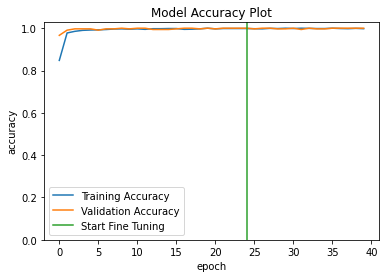

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, max(plt.ylim())+0.02])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower left')
plt.title('Model Accuracy Plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

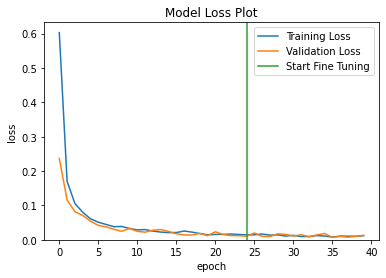

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, max(plt.ylim())])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Model Loss Plot')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()



---



# **Testing**

In order to test the model, it was made to predict the class on the test set (10 percent of original dataset which was untouched) using a test generator with a batch size of 1. By obtaining the prediction indices for each input test image, the classification report and the confusion matrix has been plotted to visualize the evaluation of the model.

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 vertical_flip=True)

In [ ]:
#change below location to test folder location
test_location = '/content/drive/My Drive/NEU surface defect database - test split/Test'

test_generator = test_datagen.flow_from_directory(test_location,
                                                  target_size=(200,200),     
                                                  batch_size=1,
                                                  class_mode=None,
                                                  shuffle = False)

Found 180 images belonging to 6 classes.


In [ ]:
step_size_test = test_generator.n//test_generator.batch_size
print(step_size_test)
test_generator.reset()

180


In [ ]:
predIndxs = model.predict_generator(test_generator, steps = step_size_test, verbose=1 )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


180/180 [==============================] - 58s 323ms/step


In [ ]:
acc_o = np.sum(np.argmax(predIndxs, axis=1).astype('int') == test_generator.labels) / test_generator.n
print(acc_o)

0.9944444444444445


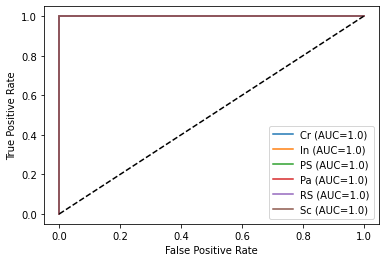

In [ ]:
auc = []
fpr_def = []
tpr_def = []
for iter_class, c in enumerate(CLASSES):
    class_target = (test_generator.labels == iter_class).astype('int')
    class_pred = predIndxs[:, iter_class]
    # Calculate AUC
    class_auc = roc_auc_score(class_target, class_pred)
    # Calculate TPR, FPR
    class_fpr, class_tpr, _ = roc_curve(class_target, class_pred)
    auc.append(class_auc)
    fpr_def.append(class_fpr)
    tpr_def.append(class_tpr)
    # Plot
    plt.plot(class_fpr, class_tpr, label=c + ' (AUC=' + str((class_auc)) + ')')
x = np.linspace(0, 1, num=100)
plt.plot(x, x, 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

Predictions for each images are printed along its associated labels . The results can also be  exported and documented as a csv format file for further evaluation of model accuracy and precision.

In [ ]:
predIndxs_max = np.argmax(predIndxs, axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print("Labels : ", labels)

predictions = [labels[k] for k in predIndxs_max]
print(predictions)

Labels :  {0: 'Cr', 1: 'In', 2: 'PS', 3: 'Pa', 4: 'RS', 5: 'Sc'}
['Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Cr', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'Sc', 'Sc', 'Sc', 'Sc', 'Sc', 'Sc'

In [ ]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv('/content/drive/My Drive/results.csv',index=False)



---



# **Results Evaluation**


The classification report with metrics such as precision, recall and f-1 score is plotted for each individual classes. As the validation accuracy is about 99.7 percent, we obtain a 100 percent the test accuracy on all test images.


*   Precision (Pr) is the ratio of relevant instance over retrieved instance. It can be calculated using the formula TP / (TP + FP).
*   Recall (Rc) is the ratio of number of relevant instance that were actually retrieved. It's calculated with the formula TP / (TP + FN).
*   F1 score is the hormonic mean of precision and recall. It's calculated by 2 * (Pr * Rc ) / (Pr + Rc).











In [ ]:
print(classification_report(test_generator.classes, predIndxs_max, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

          Cr       0.97      1.00      0.98        30
          In       1.00      1.00      1.00        30
          PS       1.00      1.00      1.00        30
          Pa       1.00      0.97      0.98        30
          RS       1.00      1.00      1.00        30
          Sc       1.00      1.00      1.00        30

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



The confusion matrix helps to visualize the predicted labels of our test images along the actaul ground truth labels. It can be noted that all test images have been correctly predicted by our model.

In [ ]:
print('Confusion matrix:')
cm = confusion_matrix(test_generator.classes,predIndxs_max)
print(cm)

total = sum(sum(cm))
print("Total test images: ", total)
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2] + cm[3, 3] + cm[4, 4] + cm[5, 5]) / total
print("Accuracy: {:.3f}".format(acc))
print("Lables:")
print("x axis: Predicted")
print("y axis: Actual")

Confusion matrix:
[[30  0  0  0  0  0]
 [ 0 30  0  0  0  0]
 [ 0  0 30  0  0  0]
 [ 1  0  0 29  0  0]
 [ 0  0  0  0 30  0]
 [ 0  0  0  0  0 30]]
Total test images:  180
Accuracy: 0.994
Lables:
x axis: Predicted
y axis: Actual


In [ ]:
normalized_cm = cm/total
print('Normalized Confusion matrix:')
print(normalized_cm)

Normalized Confusion matrix:
[[0.16666667 0.         0.         0.         0.         0.        ]
 [0.         0.16666667 0.         0.         0.         0.        ]
 [0.         0.         0.16666667 0.         0.         0.        ]
 [0.00555556 0.         0.         0.16111111 0.         0.        ]
 [0.         0.         0.         0.         0.16666667 0.        ]
 [0.         0.         0.         0.         0.         0.16666667]]


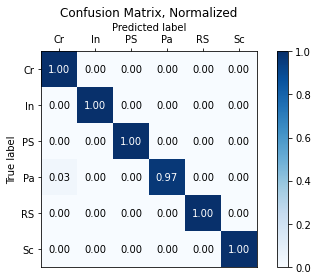

In [ ]:
target_idx = test_generator.labels
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
       xticklabels=CLASSES, yticklabels=CLASSES,
       title='Confusion Matrix, Normalized', ylabel='True label', xlabel='Predicted label')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cm[i, j] > .5 else "black")
fig.tight_layout()

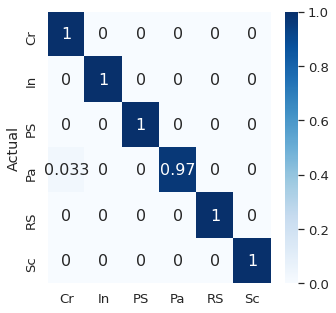

In [ ]:
plt_cm = pd.DataFrame(cm, index=test_generator.class_indices.keys(), columns=test_generator.class_indices.keys())
plt_cm.index.name = "Actual"
plt_cm.index.columns = "Predicted"
plt.figure(figsize = (5,5))
sn.set(font_scale=1.2)
sn.heatmap(plt_cm, cmap="Blues", annot=True,annot_kws={"size": 16})


The model can also be saved and loaded at any instance to reduce the training time and to increase the efficiency for the end user.

In [ ]:
model.save('/content/drive/My Drive/xai_model/LG_model.h5')

In [ ]:
saved_model = load_model('/content/drive/My Drive/xai_model/LG_model.h5')



---



# **Prediction**

Given the path of the input image, the test_img is loaded and preprocessed as per the requirement for prediction function. Now the model predicts the probability of the image belonging to each class and the output is obtained by getting the maximum value of prediction and matching it with its associated labels. The order of the prediction probability is also noted as it helps us to visualize the super-pixels responsible for the preiction of each classes by comparing them with the explanation provided by LIME.





> The ground truth annotation provided in the NEU dataset is exploited to visualize the bounding boxes for the defect region in the test images. They can be compared to the masks generated by LIME for each prediction to evaluate the accuracy and efficieny of the model built.



In [ ]:
#change below location as needed
#annotation = '/ANNOTATIONS/patches_206.xml'
annotation = '/content/drive/My Drive/NEU surface defect database - test split/Test/crack_c.xml'
#image_path = "/NEU surface defect database - test split/Test/Pa/Pa_206.bmp"
image_path = "/content/drive/My Drive/NEU surface defect database - test split/Test/crack_c.png"

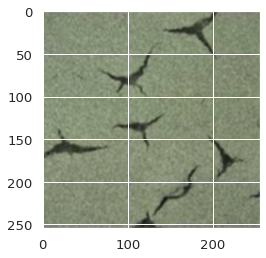

In [ ]:
test_img = image.load_img(image_path)
plt.grid(None)
plt.imshow(test_img)
plt.grid(None)

test_img = image.img_to_array(test_img)
test_img = np.expand_dims(test_img, axis=0)
test_img /= 255

In [ ]:
labels = {0: 'Crazing', 1: 'Inclusion', 2: 'Pitted Surface', 3: 'Patches', 4: 'Rolled-in Scale', 5: 'Scratches'}

result = saved_model.predict(test_img)
print(result)

prediction = result.argmax(axis=1)
print(prediction)

output = labels[int(prediction)]
print(output)

[[1.2691437e-01 8.3807737e-01 1.0107368e-02 1.7473446e-02 1.7504969e-04
  7.2524603e-03]]
[1]
Inclusion


[[1, 134, 80, 179], [67, 34, 135, 106], [144, 1, 210, 58], [82, 123, 144, 167], [100, 235, 144, 255], [189, 144, 243, 205], [128, 183, 187, 237]]


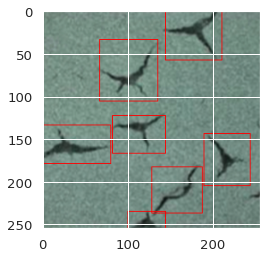

In [ ]:
def extract_boxes(filename):
	tree = ElementTree.parse(filename)
	root = tree.getroot()	
	boxes = list()
	for box in root.findall('.//bndbox'):
		xmin = int(box.find('xmin').text)
		ymin = int(box.find('ymin').text)
		xmax = int(box.find('xmax').text)
		ymax = int(box.find('ymax').text)
		coors = [xmin, ymin, xmax, ymax]
		boxes.append(coors)
	return boxes 

b_img = cv2.imread(image_path)
boxes = extract_boxes(annotation)
print(boxes)
q = np.zeros(shape = b_img.shape, dtype = "uint8")

plt.grid(None)
for i in range(len(boxes)):
  pt1 = boxes[i][0], boxes[i][1]
  pt2 = boxes[i][2], boxes[i][3]
  cv2.rectangle(b_img, pt1, pt2, (255, 0, 0), 1)
  cv2.rectangle(img = q, pt1 = pt1, pt2 = pt2, 
	color = (255, 255, 255), thickness = -1)
	
  plt.imshow(b_img)

plt.grid(None)

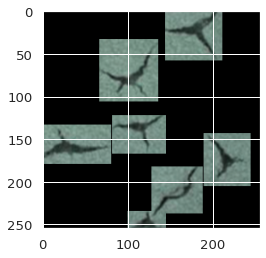

In [ ]:
b_img2 = cv2.imread(image_path)
maskedImg = cv2.bitwise_and(src1 = b_img2, src2 = q)
plt.imshow(maskedImg)

# LIME

Local Interpretable Model-agnostic Explanation (LIME) is a novel explanation technique that explains the prediction of any classifier by treating it as a 'blackbox' model, in an interpretable manner by learning an interpretable model locally around the prediction. LIME tests the variations in the predictions of the model with corresponding perturbations to the input data. So, LIME generates a new dataset for each input, consisting of permuted samples and its corresponding predictions. Then it trains an interpretable model which is weighted by the proximity of the sampled instances to the instance of interest. LIME now explains the predictions by intrepreting the local model. 



> LIME is pip installable and the necessary packages for the explanation of image classification are imported.



In [ ]:
!pip install lime

     |████████████████████████████████| 276kB 6.8MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=1bbb0f9cb5c720233ea8a8a4e04dadedd8e6ac85ec5a581c270439db6b80f404
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
%load_ext autoreload
%autoreload 2
import os, sys
import lime
from lime import lime_image

In [ ]:
explainer = lime_image.LimeImageExplainer()

The 'explain_instance' function gets the input test image and the model's prediction values and generates the masks in terms of super-pixels which are responsible for the classification of the test image to a particular class. By changing the 'top_labels' attribute, the number of masks to be generated for each test image is determined. It's assigned value 6 denotes the number of classes in our dataset.



> The explanation function takes about 6 secs for each image with GPU processing and it has been recorded to be about 10 minutes under normal CPU.


In [ ]:
%%time

explanation = explainer.explain_instance(test_img[0], saved_model.predict, top_labels=6, hide_color=0)


CPU times: user 2min 25s, sys: 12.8 s, total: 2min 38s
Wall time: 17 s


In [ ]:
labels = {0: 'Crazing', 1: 'Inclusion', 2: 'Pitted Surface', 3: 'Patches', 4: 'Rolled-in Scale', 5: 'Scratches'};
print("Predictions: \n")
for i in range(len(explanation.top_labels)):
  rank = explanation.top_labels[i]
  print(i,labels[rank])  

Predictions: 

0 Inclusion
1 Crazing
2 Patches
3 Pitted Surface
4 Scratches
5 Rolled-in Scale


Given the order of the probability of prediction, the value of 'p' is set to visualize the patches responsible for its classification. 'p' set to 0 explains the top prediction by the model.

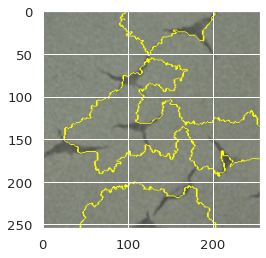

In [ ]:
p = 0
temp, mask = explanation.get_image_and_mask(explanation.top_labels[p], positive_only=True, num_features=10, hide_rest=False)
plt.grid(None)
plt.imshow(mark_boundaries(temp / 2 + 0.25, mask))
plt.grid(None)

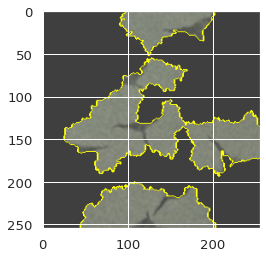

In [ ]:
p = 0
temp, mask = explanation.get_image_and_mask(explanation.top_labels[p], positive_only=True, num_features=10, hide_rest=True)
plt.grid(None)
plt.imshow(mark_boundaries(temp / 2 + 0.25, mask))
plt.grid(None)

To increase the interpretabilty of LIME, 'hide_rest' attribute is set to 'True' as it sets the values of pixels other than the chosen super-pixels to gray. 

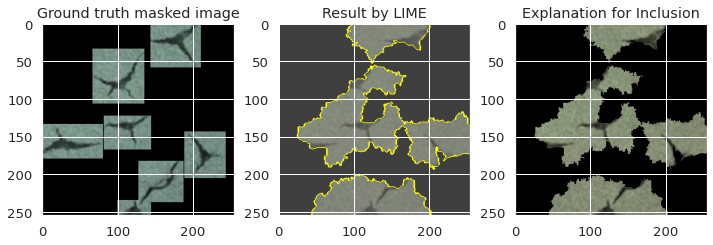

In [ ]:
p = 0
temp, mask = explanation.get_image_and_mask(explanation.top_labels[p], positive_only=True, 
                                            num_features=10, hide_rest=True)
top = labels[explanation.top_labels[p]]
title = "Explanation for " + top

plt.figure(figsize=(12, 12))
plt.subplot(3,3,1)
plt.imshow(maskedImg)
plt.grid(None)
plt.title('Ground truth masked image')
plt.grid(None)

plt.subplot(3,3,2)
plt.imshow(mark_boundaries(temp / 2 + 0.25, mask))
plt.grid(None)
plt.title('Result by LIME')
plt.grid(None)

plt.subplot(3,3,3)
plt.imshow(temp)
plt.grid(None)
plt.title(title)
plt.grid(None)

By changing the value of 'positive_only' attribute to False, we can get the pixels responsible for a particular classification to 'green' shade and the pixels which affects the classification to 'red' shade. It can be noted that the value of 'num_features' can be modified which is set as a complexity measure for minimising the loss function.

The input test image along its ground truth bounding boxes and the explanations by LIME are plotted together to interpret 

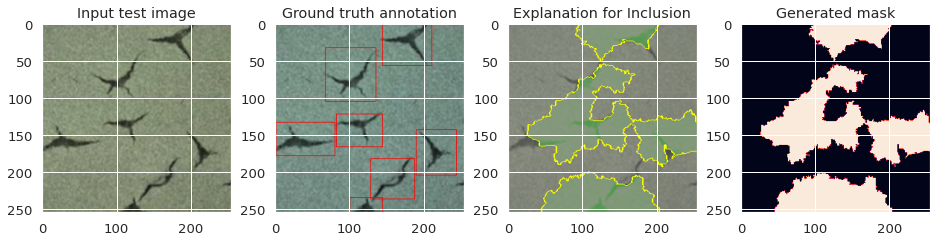

In [ ]:
p = 0
temp, mask = explanation.get_image_and_mask(explanation.top_labels[p], positive_only=False, 
                                            num_features=10, hide_rest=False)
top = labels[explanation.top_labels[p]]
title = "Explanation for " + top

plt.figure(figsize=(16, 16))
plt.subplot(4,4,1)
plt.imshow(test_img[0])
plt.grid(None)
plt.title('Input test image')
plt.grid(None)

plt.subplot(4,4,2)
plt.imshow(b_img)
plt.grid(None)
plt.title('Ground truth annotation')
plt.grid(None)

plt.subplot(4,4,3)
plt.imshow(mark_boundaries(temp / 2 + 0.25, mask))
plt.grid(None)
plt.title(title)
plt.grid(None)

plt.subplot(4,4,4)
plt.imshow(mask)
plt.grid(None)
plt.title('Generated mask')
plt.grid(None)

# SHAP

SHapley Additive exPlanation [SHAP](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf) is a unified framework for interpreting predictions of a 'blackbox' models. SHAP explains the prediction of an instance by computing the contribution of each feature to the prediction. The 'GradientExplainer' method is used for visualizing those contributions of each pixel at the layer level. Both positive and negative SHAP values are plotted and the explanation needed at a particular layer can be provided as an input by the user. Thus, SHAP evaluates a model by assigning each feature an importance value towards a particular prediction. SHAP values can be visualized for all 6 classes of the NEU dataset at a given time which helps to quickly evaluate the results.


In [ ]:
!pip install shap

     |████████████████████████████████| 358kB 6.7MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp37-cp37m-linux_x86_64.whl size=490506 sha256=49cc7b57d878fbb59286bc2a68caec56241a5687ad887e40cc1a541b26f1669d
  Stored in directory: /root/.cache/pip/wheels/a8/fb/e4/88012be41842b9be62ae18d82d1b1e880daf8539d1fef1fa00
Successfully built shap


SHAP is pip installable. All 1800 images from the original dataset is read and loaded in the variable 'shap_background', which acts like a distribution model over which the test image is approximated with respect to its SHAP values.

In [ ]:
#change below locations as needed

shap_Cr = '/NEU surface defect database - test split/Train/Cr/*.bmp'
shap_In = '/NEU surface defect database - test split/Train/In/*.bmp'
shap_PS = '/NEU surface defect database - test split/Train/PS/*.bmp'
shap_Pa = '/NEU surface defect database - test split/Train/Pa/*.bmp'
shap_RS = '/NEU surface defect database - test split/Train/RS/*.bmp'
shap_Sc = '/NEU surface defect database - test split/Train/Sc/*.bmp'

shap_data = [shap_Cr, shap_In, shap_PS, shap_Pa, shap_RS, shap_Sc]

In [ ]:
%%time

cv_img = []

for i in range(len(shap_data)):
  for ig in glob.glob(shap_data[i]):
    n = cv2.imread(ig)
    cv_img.append(n)

shap_background = np.array(cv_img)

CPU times: user 0 ns, sys: 529 µs, total: 529 µs
Wall time: 538 µs


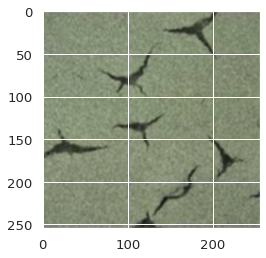

In [ ]:
shap_test = image.load_img(image_path)
plt.grid(None)
plt.imshow(shap_test)
plt.grid(None)

shap_test = image.img_to_array(shap_test)
shap_test = np.expand_dims(shap_test, axis=0)

All the layers of our model are displayed, from which the layer to access with explainability is given as input 'm' to the 'GradientExplainer' method. The number of outputs preferred to be displayed are choosen using 'ranked_outputs' variable and 'local_smoothing' can be modified to get smoother feature attribute which adds a normally distribued noise with the provided standard deviation.

In [ ]:
for i in range(len(saved_model.layers)):
  print(i , saved_model.layers[i])

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f48506757d0>
1 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4850675c90>
2 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f4851926e50>
3 <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f4850675dd0>
4 <tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7f48532c6690>
5 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f4851926490>
6 <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f4852414650>
7 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f485067bad0>
8 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f48519ff910>
9 <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f48532d5890>
10 <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f48519fdf90>
11 <tensorflow.python.keras.la

In [ ]:
%%time

import shap
m = 15

def map2layer(x, layer):
  feed_dict = dict(zip([saved_model.layers[0].input], [preprocess_input(x.copy())]))  
  return K.get_session().run(saved_model.layers[layer].input, feed_dict)

e = shap.GradientExplainer((saved_model.layers[m].input, saved_model.layers[-1].output),
                           map2layer(preprocess_input(shap_background.copy()),m), local_smoothing = 0)

TypeError: ignored

In [ ]:
def map2layer(x, layer):
  feed_dict = dict(zip([saved_model.layers[0].input], [preprocess_input(x.copy())]))  
  return K.get_session().run(saved_model.layers[layer].input, feed_dict)

shap_values, indexes = e.shap_values(map2layer(shap_test, m), ranked_outputs=3)

index_names = np.vectorize(lambda l: labels[l])(indexes)

shap.image_plot(shap_values, shap_test, index_names)

NameError: ignored